# Content-Based RS

In this step we will implement the Rocchio model, a simple content-based RS. 
For this reason, you must do:

- Read the train file extracted from the dataset 
- Read the 0-1 file related to the movies features
- Create a sparse matrix to them
- Implement the Rocchio model and save the items recommended

In [1]:
# import libs
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from collections import OrderedDict
from sklearn.metrics.pairwise import cosine_similarity

# useful command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

plt.rcParams.update({'font.size': 14})

## Reading train and items' features files

You can read this file as you prefer. I propose to read the files by the pandas' library and create the sparse matrix after it.

In [2]:
df_train = pd.read_csv('../Dataset/ML-1M/trainSet.txt', sep='::', names=['userId', 'itemId', 'rating', 'timestamp'])
df_test = pd.read_csv('../Dataset/ML-1M/testSet.txt', sep='::', names=['userId', 'itemId', 'rating', 'timestamp'])
df_features = pd.read_csv('../Dataset/ML-1M/features-items.txt', sep=',')

df_train.head()
df_features.head()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,userId,itemId,rating,timestamp
0,1,1193,5.0,978300760.0
1,1,661,3.0,978302109.0
2,1,914,3.0,978301968.0
3,1,3408,4.0,978300275.0
4,1,1197,3.0,978302268.0


,MovieId,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Creating Sparse Matrix

I propose to use the csr_matrix from scipy.

In [3]:
# Select users, items and ratings logs (i.e., all information from each column)
users = df_train['userId']
items = df_train['itemId']
ratings = df_train['rating']

In [4]:
# Define the matrix dimensions based on the max index related to users and items
nb_users = max(users)
nb_items = max(items)

In [5]:
# Creating matrix of ratings
ratings_matrix = csr_matrix((ratings, (users, items)), shape=(nb_users+1, nb_items+1))

ratings_matrix.shape

(6041, 3953)

In [6]:
# Select items and features
nb_items = max(df_features['MovieId'])
nb_features = len(df_features.columns) - 1

In [7]:
# Creating matrix of items' features all zero
features_matrix = csr_matrix((nb_items+1, nb_features+1))

features_matrix.shape

(3953, 19)

In [8]:
f = open('../Dataset/ML-1M/features-items.txt', 'r')

# ignore header
row = f.readline()

for row in f:
    row = row.rstrip()
    values = row.split(',')
    itemId = int(values.pop(0))
    featureId = 0
    for v in values:
        features_matrix[itemId, featureId] = int(v)
        featureId += 1 
        
f.close()

/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [9]:
features_matrix.shape

(3953, 19)

## An useful function

This function is used to save the recommendations in a file.

In [10]:
def dumpRecommendation(recommendation, users_targets, file_name):
    
    file_out = open(file_name, 'w')
    
    # for each user target
    for userId in users_targets:
        issuedItems = ""
        # for each item in the previous order
        for itemId in recommendation[userId]:
            issuedItems += str(itemId) + ":" + str(0.0) + ","
        # saving in file in correct format
        string_s = str(userId) + "\t" + "[" + issuedItems
        string_out = string_s[:-1] + ']'
        file_out.write(string_out + "\n")
    
    file_out.close()

## Rocchio Recommendation

In Rocchio model, the prediction is based on the similarity (e.g., cosine) between items and users:

- Each item is a vector of features _(similar to features-matrix)_
- Each user is a mix of his/her items consumed:
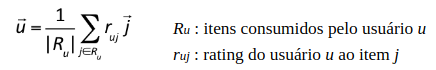

### Representing users by features

In [11]:
# Creating matrix of users' features all zero
users_matrix = csr_matrix((nb_users+1, nb_features+1))

users_matrix.shape

(6041, 19)

In [12]:
# Matrix multiplication
aux = np.dot(ratings_matrix, features_matrix)
aux.shape

(6041, 19)

In [13]:
# Normalizing them by the size of user historic
for u in range(ratings_matrix.shape[0]):
    # measuring the items nonzero
    nb_nonzero = len(np.nonzero(ratings_matrix[u,:])[1])
    # multiplying this
    if (nb_nonzero != 0):
        users_matrix[u,:] = np.dot(1/float(nb_nonzero), aux[u,:])

users_matrix.shape

/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


(6041, 19)

### Recommending items

The recommendation is related to the cosine similarity of users and items vectors.

In [14]:
features_matrix.shape

(3953, 19)

In [15]:
# consine similarity between each item
prediction_matrix = cosine_similarity(users_matrix, features_matrix)
prediction_matrix.shape

(6041, 3953)

In [16]:
# Size of each recommendation
top_k = 10

In [17]:
# Setting the recommendations for each user
recommendation = {}

for u in range(ratings_matrix.shape[0]):
    recommendation[u] = []
    cont = 0
    # sorting items by relevance
    order = np.argsort(prediction_matrix[u,:])[::-1]
    # recommending the best items that have never seen by users
    for i in order:
        # recommending the top-k items 
        if (cont < top_k):
            if (ratings_matrix[u,i] == 0):
                recommendation[u].append(i)
                cont += 1
        else:
            break

In [18]:
# Save in a file
users_targets = df_test['userId'].unique()
dumpRecommendation(recommendation, users_targets, "../Recommendation/ML-1M/recList_Rocchio.txt")

In [19]:
recommendation[300]
recommendation[3000]
recommendation[6010]

[390, 21, 1916, 3180, 3817, 1723, 3381, 3083, 1115, 537]

[1127, 1917, 849, 1591, 1544, 1215, 1720, 173, 316, 2641]

[1916, 390, 2924, 3275, 360, 2170, 1858, 3740, 438, 1866]

In [ ]:
## Toy example
A = csr_matrix([[1,0,4,0,5,0,2,0,0,5], 
                [0,2,0,3,0,3,5,0,1,0], 
                [4,0,0,0,4,0,3,0,0,2], 
                [0,2,1,4,0,0,1,3,0,3], 
                [3,0,4,0,3,5,0,0,4,0]])

B = csr_matrix([[1,1,0,0], [0,1,0,1], [1,0,1,0], [0,1,1,1], [1,0,0,1], 
                [1,1,0,0], [0,1,1,1], [1,0,0,0], [1,0,1,1], [1,0,1,0]])

nb_users = 5
nb_items = 10
nb_features = 4